# Top 14 Rugby ?

par Benjamin Cerf, Tristan Delhaye & Mathieu Roig

<a id="intro"></a>
# Introduction

à rédiger, 
+ Démarche scientifique et reproductibilité du projet

<a id="sommaire"></a>
### Sommaire
- [Introduction](#intro)
  - [Sommaire](#sommaire)
  - [Installation](#installation)
- [Données](#données)
  - [Web-Scraping](#scraping)
  - [Nettoyage](#nettoyage)
  - [Regroupement](#regroupement)
  - [Mapping des noms de clubs](#mapping)
- [Statistiques Descriptives](#stats)
  - [Visualisation](#visual)
  - [Analyse](#analyse)
- [Modèle prédictif](#predict)
- [Conclusion](#conclu)

<a id="installation"></a>
### Installation

In [1]:
#packages:
from io import StringIO
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import sys
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#lxml
subprocess.check_call([sys.executable, "-m", "pip", "install", "lxml"])

# ajouter pour partie predict

0

<a id="données"></a>
# Données

<a id="scraping"></a>
### Web-Scraping

Nous récupérons sur Wikipédia les données sur le championnat de France de rugby à XV de 2016 à aujourd'hui. Chaque saison a sa propre page wikipédia dédiée et la présentation des résultats peut légèrement différer en fonction de l'année: voir ici la saison [2016-2017](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017) par rapport à la saison [2024-2025](https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025).

In [2]:
urls = [f"https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_{year}-{year+1}"
    for year in range(2016, 2025)]
print(urls)

['https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2016-2017', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2017-2018', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2018-2019', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2019-2020', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2020-2021', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2021-2022', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2022-2023', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2023-2024', 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_rugby_%C3%A0_XV_2024-2025']


Nous utilisons donc plusieurs versions d'une même fonction data dans scrapData.py qui récupère les tableaux de présentation générale, du classement, de son évolution, les résultats détaillés par match, et aussi la forme des équipes en fonction des jours de match.

In [3]:
sys.path.append(os.path.abspath('./scripts'))
from scrapData import data2325, data2223, data2122, data2021, data1920, data1619

tab1617 = data1619(urls[0])
tab1718 = data1619(urls[1])
tab1819 = data1619(urls[2])
tab1920 = data1920(urls[3])
tab2021 = data2021(urls[4])
tab2122 = data2122(urls[5])
tab2223 = data2223(urls[6])
tab2324 = data2325(urls[7])
tab2425 = data2325(urls[8])

<a id="nettoyage"></a>
### Nettoyage

La fonction nettoyage de cleanData.py uniformise les données du scraping. Les noms des équipes sont nettoyés, on se débarrasse des notes, et les classements sont tous mis sous forme numérique (ex: 1er -> 1, 2ème -> 2...). Les valeurs manquantes sont aussi remplacées par un tiret.

In [4]:
from cleanData import nettoyage

nettoyage(*tab1617)
nettoyage(*tab1718)
nettoyage(*tab1819)
nettoyage(*tab1920)
nettoyage(*tab2021)
nettoyage(*tab2122)
nettoyage(*tab2223)
nettoyage(*tab2324)
nettoyage(*tab2425)

<a id="regroupement"></a>
### Regroupement

Chaque tab est en réalité une liste de 5 dataframes. Nous allons donc pour chaque tableau fusionner les résultats des 9 dernières années, sauf celui des résultats globaux. 

In [5]:
# On va maintenant fusionner les tableaux, on change le nom pour faciliter la boucle :
tab1 = tab1617
tab2 = tab1718
tab3 = tab1819
tab4 = tab1920
tab5 = tab2021
tab6 = tab2122
tab7 = tab2223
tab8 = tab2324
tab9 = tab2425

# On crée une fonction qui permet d'ajouter une colonne année à chaque tableau pour bien pouvoir les séparer par année si besoin après
def ajout_an(df,i):
   df["année"] = 2016 + i
   return df

# On va faire maintenant une boucle pour concaténer les tableaux entre eux :
tableauglobal = [pd.DataFrame() for _ in range(5)]
# On remarquera que l'on ne prend pas le tableau résultat global car les équipes du championnat changent chaque année donc ce n'est pas possible de le concaténer

for j in range(1, 10):
    for i in range(5):
        if i == 2:
            pass  # on ne récupère pas le tableau résultat
        else:
         tableauglobal[i] = pd.concat([tableauglobal[i], ajout_an(eval(f"tab{j}")[i], j - 1)], ignore_index=True)

tab_presentation_global = tableauglobal[0]
tab_classement_global = tableauglobal[1]
tab_evolution_classement_global = tableauglobal[3]
tab_forme_global = tableauglobal[4]
tab_presentation_global['Budget en M€'] = pd.to_numeric(tab_presentation_global['Budget en M€'], errors='coerce')
tab_presentation_global['Classement précédent'] = pd.to_numeric(tab_presentation_global['Classement précédent'], errors='coerce')


<a id="mapping"></a>
### Mapping des noms de clubs

Enfin certaines équipes n'ont pas toujours leur nom écrit de la même façon. On trouve les différences d'appellations en recherchant les clés uniques et on les compare à celles du classement de présentation pour les uniformiser. Par exemple 'Stade français Paris'->'Stade français'. Nous procédons de même avec les différents tableaux pour observer toutes les appellations différentes (toujours par rapport à classement). 

In [6]:
presentation = tab_presentation_global
classement = tab_classement_global
evolution = tab_evolution_classement_global
forme = tab_forme_global

#On va fusionner les tableaux en se servant du club et de l'année comme clef
#uniformiser le nom de la colonne 'Club':
evolution.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)
forme.rename(columns={'Equipes/Journées': 'Club'}, inplace=True)

#On répertorie alors ces appelations différentes pour pouvoir par la suite uniformiser tout les noms : 

mapping = {
    'Paris' : 'Stade français Paris',
    'Stade français': 'Stade français Paris',
    'Clermont': 'ASM Clermont',
    'La Rochelle': 'Stade rochelais',
    'Toulouse': 'Stade toulousain',
    'Bayonne': 'Aviron bayonnais',
    'Brive': 'CA Brive',
    'Montpellier': 'Montpellier HR',
    'Toulon': 'RC Toulon',
    'Castres': 'Castres olympique',
    'Pau': 'Section paloise',
    'Agen': 'SU Agen',
    'Grenoble': 'FC Grenoble',
    'Oyonnax': 'US Oyonnax',
    'Perpignan': 'USA Perpignan',
    'Bordeaux-Bègles': 'Union Bordeaux Bègles',
    'Bordeaux Bègles' : 'Union Bordeaux Bègles',
    'Lyon' : 'Lyon OU'
}

presentation['Club'] = presentation['Club'].replace(mapping)
classement['Club'] = classement['Club'].replace(mapping)
forme['Club'] = forme['Club'].replace(mapping)
evolution['Club'] = evolution['Club'].replace(mapping)

#print(presentation.describe())
#print(classement.describe())
#print(forme.describe())
#print(evolution.describe())

On agrège ensuite les différents tableaux en un seul dataframe nommé données, pour les stocker dans le dossier data. Si nos données étaient plus volumineuses, nous pourrions aussi les stocker dans le S3.

In [17]:
data = pd.merge(presentation, classement, on=['Club', 'année'], how='inner')
data = pd.merge(data, evolution, on=['Club', 'année'], how='inner')
data = pd.merge(data, forme, on=['Club', 'année'], how='inner')

data.to_csv('./data/données.csv', index=False)

#ou fixer les données nettoyées dans SSPcloud ?
#import s3fs
#MY_BUCKET =

<a id="stats"></a>
# Statistiques Descriptives

<a id="visual"></a>
### Visualisation

La fonction club de computeData permet d'obtenir les statistiques descriptives pour un club en particulier, pour chaque année qu'il passe dans le top 14: son budget en M€, son entraîneur, son rang, et le nombre de rencontres jouées, dont les victoires et les défaites, et encore le différentiel total de points marqués ou encaissés.

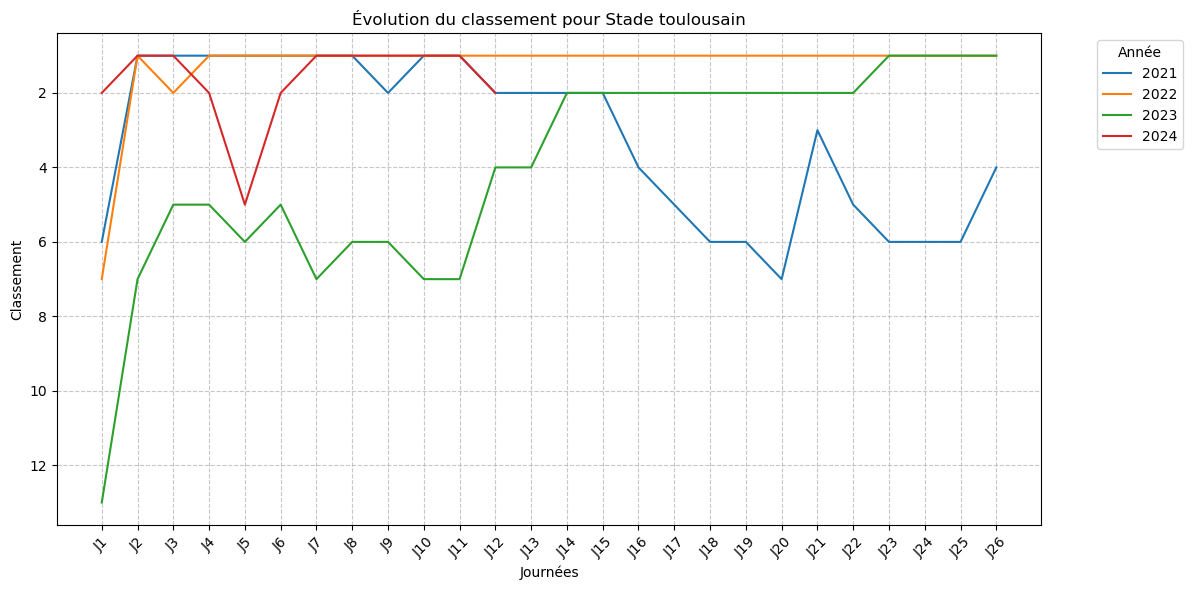

/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in

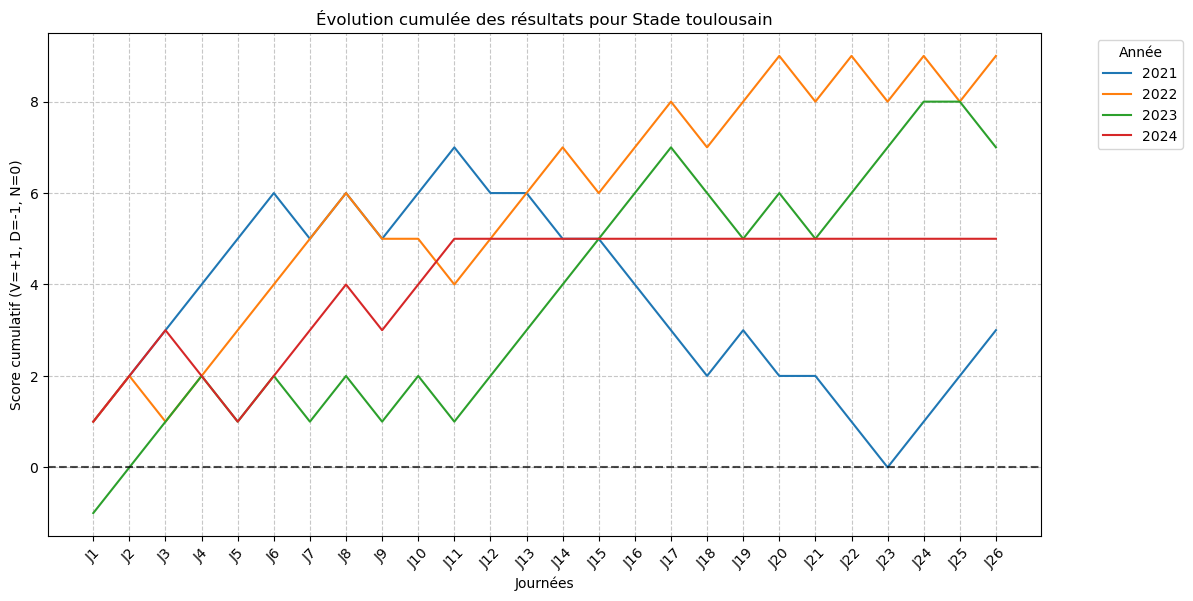

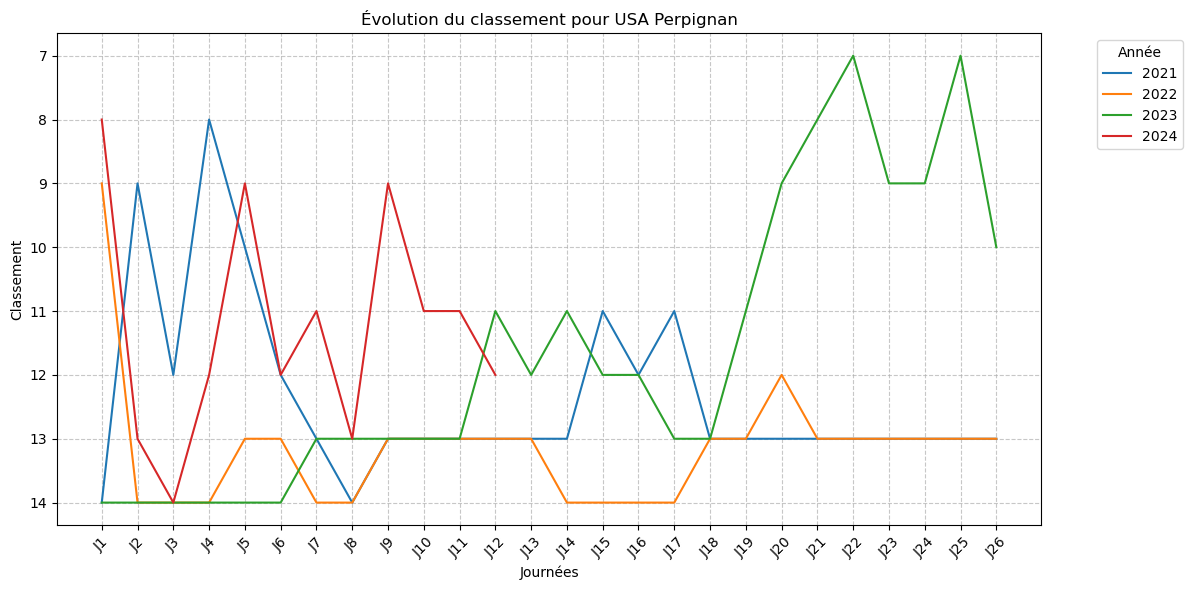

/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_numeric = resultats_data.iloc[i].replace({'V': 1, 'D': -1, 'N': 0, 'R': 0, '': 0}).fillna(0).astype(int)
/home/onyxia/work/Projet-Python/scripts/computeData.py:181: FutureWarning: Downcasting behavior in

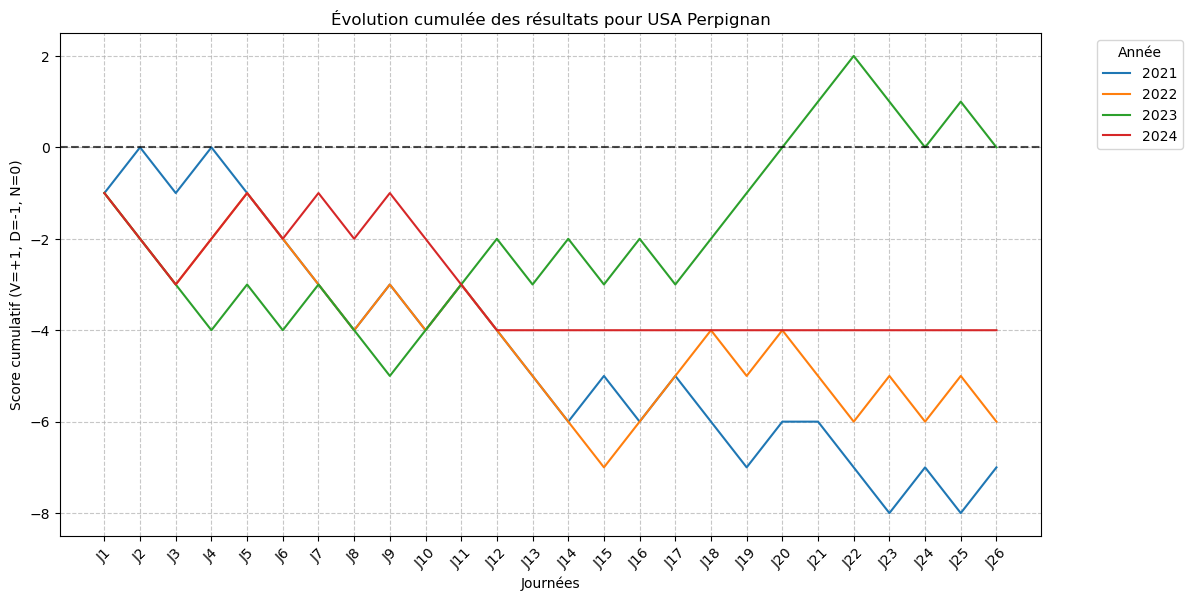

                       24/25     23/24     22/23     21/22     20/21  \
Budget en M€            49.0      46.3       NaN      37.3      36.6   
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola   
Rang                       2         1         1         4         1   
J                         12        26        26        26        26   
V                          8        16        17        15        17   
D                          3         9         8        11         8   
Diff                     159       173       208       206       210   

                       19/20     18/19     17/18     16/17  
Budget en M€            37.2      32.0     30.86      31.5  
Entraîneur en chef  Ugo Mola  Ugo Mola  Ugo Mola  Ugo Mola  
Rang                       7         1         3        12  
J                         17        26        26        26  
V                          8        21        16        11  
D                          8         3         9        1

In [8]:
from computeData import club

#par exemple pour Toulouse, le plus titré en championnat de France avec 23 victoires:
toulouse=club("Stade toulousain", tab_presentation_global, tab_classement_global)
print(toulouse)
#ou Perpignan:
perpignan=club("USA Perpignan", tab_presentation_global, tab_classement_global)
print(perpignan)

On peut aussi visualiser l'évolution du budget des clubs au sein du championnat. La page Wikipédia de l'année 2022 n'indique d'ailleurs pas le budget des clubs. Celui-ci évolue en moyenne de 24M€ à 30M€, une augmentation de 25% à comparer avec l'inflation cumulée de l'euro entre 2016 et 2024 qui était de 17,5%.
On peut remarquer deux outliers: et le SU Agen avec 12M€ de budget en 2017, et puis le Stade Toulousain en 2024 avec 49M€ de budget.

/tmp/ipykernel_121564/2143594578.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")


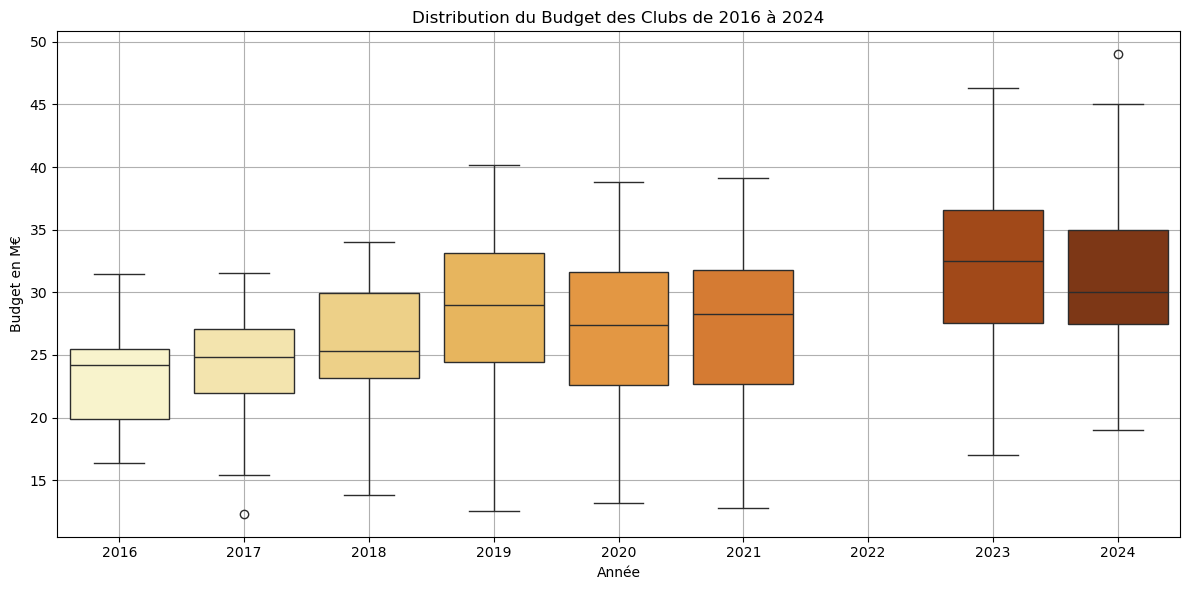

In [9]:
data_filtered = data[data["année"].isin(range(2016, 2025))]
plt.figure(figsize=(12, 6))
sns.boxplot(x="année", y="Budget en M€", data=data_filtered, palette="YlOrBr")

plt.title("Distribution du Budget des Clubs de 2016 à 2024")
plt.xlabel("Année")
plt.ylabel("Budget en M€")

plt.grid(True)
plt.tight_layout()
plt.show()

#data_2022 = data[data["année"] == 2022]
#print(data_2022[["Club", "Budget en M€"]])


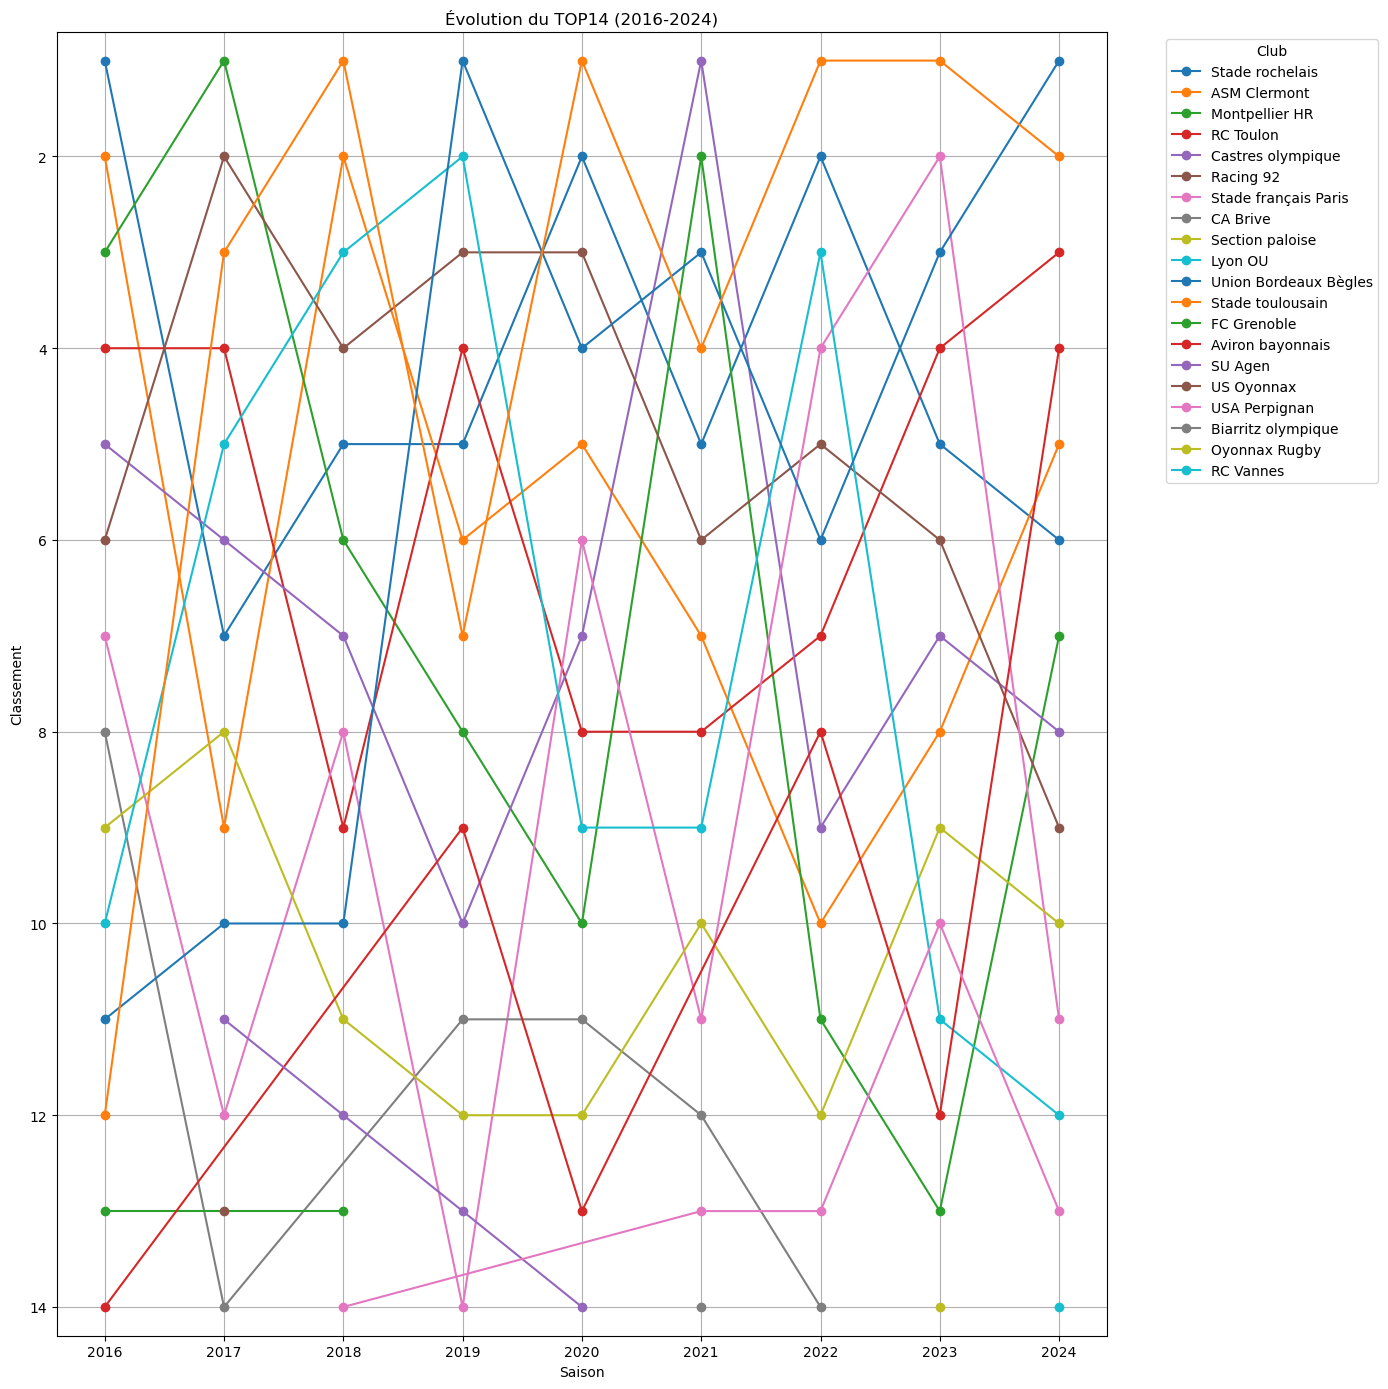

In [10]:
#filtrer pour le top?
top_10_per_year = (
    data.sort_values(by=["année", "Rang"])
    .groupby("année")
    .head(14)
    .sort_values(by=["année", "Rang"])
)

plt.figure(figsize=(14, 14))
for club in top_10_per_year["Club"].unique():
    club_data = top_10_per_year[top_10_per_year["Club"] == club]
    plt.plot(club_data["année"], club_data["Rang"], marker="o", label=club)

plt.gca().invert_yaxis()  # le 1 en haut !
plt.ylim(14.3, 0.7) # pour choisir le top

plt.title("Évolution du TOP14 (2016-2024)")
plt.xlabel("Saison")
plt.ylabel("Classement")
plt.legend(title="Club", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

On peut représenter l'évolution du TOP14 en entier, mais le graphique ci-dessus n'est pas très lisible.
Partant du principe qu'on ne change pas une équipe qui gagne, représentons uniquement les clubs ayant gagné un championnat depuis 2016 pour visualiser le TOP5.

In [11]:
tier_1_clubs = data[data["Rang"] <= 1]["Club"].unique()
filtered_data = data[data["Club"].isin(top_3_clubs)]
top_14_per_year = (
    filtered_data.sort_values(by=["année", "Rang"])
    .groupby("année")
    .head(14)
    .sort_values(by=["année", "Rang"])
)

plt.figure(figsize=(12, 5))
for club in top_14_per_year["Club"].unique():
    club_data = top_14_per_year[top_14_per_year["Club"] == club]
    plt.plot(club_data["année"], club_data["Rang"], marker="o", label=club)

plt.gca().invert_yaxis()
plt.ylim(5.3, 0.7) 

plt.title("Évolution du TOP14 (2016-2024) - Clubs titrés")
plt.xlabel("Saison")
plt.ylabel("Classement")
plt.legend(title="Club", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'top_3_clubs' is not defined

Les deux favoris pour remporter la saison 2024-2025 semblent donc être l'Union Bordeaux-Bègles et le Stade Toulousain. En plus d'être historiquement le plus titré, le Stade Toulousain a le plus gros budget de la saison.

<a id="analyse"></a>
### Analyse

In [13]:
from computeData import plot_club_evolution
#plot_club_evolution("Stade toulousain", tab_classement, tab_resultats)
plot_club_evolution("Stade toulousain", tab_evolution_classement_global, tab_forme_global)


KeyError: 'Equipes/Journées'

<a id="predict"></a>
# Modèle prédictif

<a id="partie1"></a>
### Partie 1 ?

<a id="partie2"></a>
### Partie 2 ?

<a id="conclu"></a>
# Conclusion

à rédiger, rester réaliste et dire ce qu'on aurait pu faire de mieux